
## TW9 Unsupervised Learning

### Clustering

Basic use of common clustering models

- K-means

- DBSCAN



### Set up

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import seaborn as sn
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "clustering_kmeans"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Utility functions

In [2]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)
    plt.show()

    
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

## K-means model

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.
    
    
The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. 

See the details of these hyperparameters: 

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### 1. A synthetic dataset

This example creates a synthetic dataset with make_blobs, then applies k-means to find 3 clusters, and plots the points in each cluster identified by a corresponding color.

#### Generate a dataset

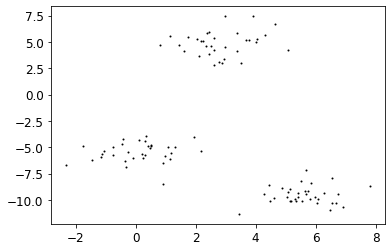

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state = 10)

plot_data(X)




#### K-means model 

In [4]:
from sklearn.cluster import KMeans

# create a K-means model
kmeans = KMeans(n_clusters=3, init='random', n_init=1, max_iter=10, algorithm='full')


In [5]:
# fit the model
kmeans.fit(X)

KMeans(algorithm='full', init='random', max_iter=10, n_clusters=3, n_init=1)

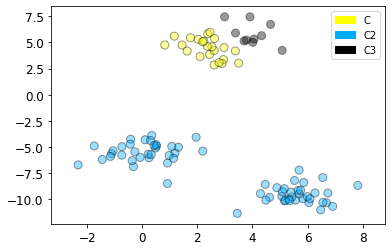

In [6]:
# plot the resulting clusters

plot_labelled_scatter(X, kmeans.labels_, ['C', 'C2', 'C3'])

### 2. Real dataset: Fruit dataset

#### Load the data

A data file: ./data/fruit_data_with_colors.txt

In [7]:
fruits = pd.read_csv('./data/fruit_data_with_colors.txt', sep='\t', engine='python')


fruits.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [8]:
# Since this dataset already include class labels, we can evaluate the model based on that
# Have X and y

X = fruits[['mass', 'width', 'height', 'color_score']].values
y = fruits[['fruit_label']]-1

print(X)
print(y)

[[192.     8.4    7.3    0.55]
 [180.     8.     6.8    0.59]
 [176.     7.4    7.2    0.6 ]
 [ 86.     6.2    4.7    0.8 ]
 [ 84.     6.     4.6    0.79]
 [ 80.     5.8    4.3    0.77]
 [ 80.     5.9    4.3    0.81]
 [ 76.     5.8    4.     0.81]
 [178.     7.1    7.8    0.92]
 [172.     7.4    7.     0.89]
 [166.     6.9    7.3    0.93]
 [172.     7.1    7.6    0.92]
 [154.     7.     7.1    0.88]
 [164.     7.3    7.7    0.7 ]
 [152.     7.6    7.3    0.69]
 [156.     7.7    7.1    0.69]
 [156.     7.6    7.5    0.67]
 [168.     7.5    7.6    0.73]
 [162.     7.5    7.1    0.83]
 [162.     7.4    7.2    0.85]
 [160.     7.5    7.5    0.86]
 [156.     7.4    7.4    0.84]
 [140.     7.3    7.1    0.87]
 [170.     7.6    7.9    0.88]
 [342.     9.     9.4    0.75]
 [356.     9.2    9.2    0.75]
 [362.     9.6    9.2    0.74]
 [204.     7.5    9.2    0.77]
 [140.     6.7    7.1    0.72]
 [160.     7.     7.4    0.81]
 [158.     7.1    7.5    0.79]
 [210.     7.8    8.     0.82]
 [164.  

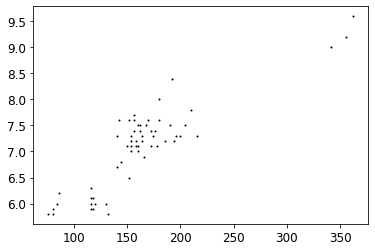

In [9]:
# plot the data (only use 2 attributes, 'mass', 'width')

plot_data(X)

#### Standarizing the data (scaling)

- Note that in general, it's important to scale the individual features before applying k-means clustering.

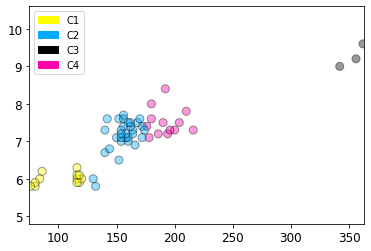

In [10]:
from sklearn.cluster import KMeans

# create a K-means model
# set hyperparameter n_clusters=4, init = 'k-means++' and algorithm = 'elkan'

kmeans = KMeans(n_clusters=4, init='k-means++', n_init=3, max_iter=500, algorithm='elkan')


# fit the model with the data
kmeans.fit(X)

# plot the cluster
plot_labelled_scatter(X, kmeans.labels_, ['C1', 'C2', 'C3', 'C4'])

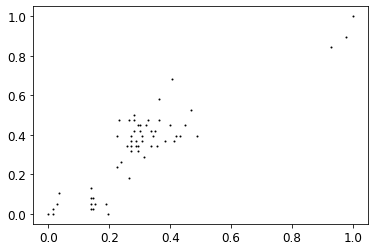

In [11]:
from sklearn.preprocessing import MinMaxScaler

# normalized the data

X_normalized = MinMaxScaler().fit(X).transform(X)

# plot the data

plot_data(X_normalized)

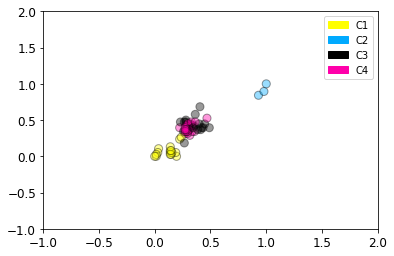

In [12]:
from sklearn.cluster import KMeans

# create a K-means model
# set hyperparameter n_clusters=4, init = 'k-means++' and algorithm = 'elkan'

kmeans = KMeans(n_clusters=4, init='k-means++', n_init=3, max_iter=500, algorithm='elkan')


# fit the model with the data
kmeans.fit(X_normalized)

# plot the cluster
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2', 'C3', 'C4'])

#### K-means model

- This example showing k-means used to find 4 clusters in the fruits dataset.

## k-means vs. DBSCAN clustering

### 1. A simple dataset

#### Generate a dataset

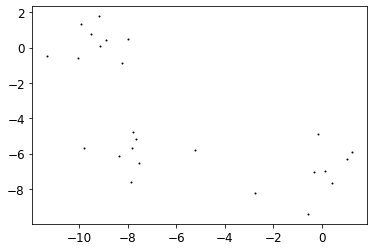

In [13]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state = 9, n_samples = 25)

plot_data(X)

#### K-means model

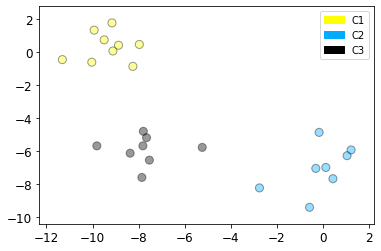

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

plot_labelled_scatter(X, kmeans.labels_, ['C1', 'C2', 'C3'])






#### DBSCAN model

Read the description of the model parameters

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

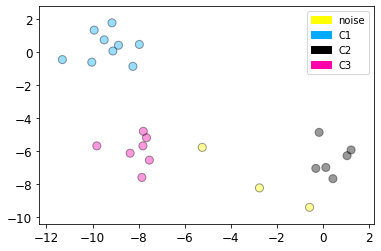

In [15]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=2, min_samples=2)
dbscan.fit(X)

plot_labelled_scatter(X, dbscan.labels_+1, ['noise', 'C1', 'C2', 'C3'])





## TW9 Tasks

### Part 1 

### (1) Apply the following clustering models on a more complex dataset below. 

- K-means

- DBSCAN

### A more complicated dataset

#### Generate a synthetic dataset

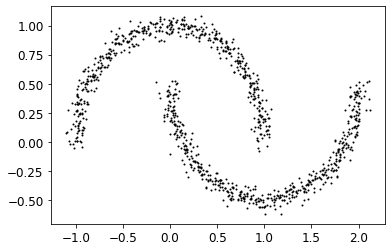

In [16]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

plot_data(X)

#### K-means model


- Apply k-means model

- use k = 2

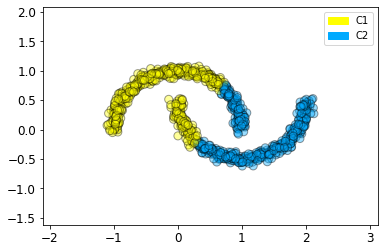

In [17]:

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

plot_labelled_scatter(X, kmeans.labels_, ['C1', 'C2'])



#### DBSCAN model

- Apply DBSCAN model

- use eps=0.2, min_samples=5

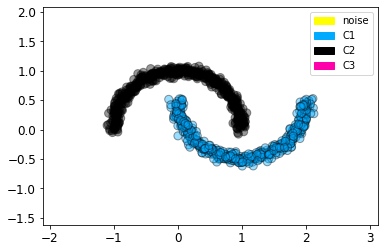

In [18]:

from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(X)

plot_labelled_scatter(X, dbscan.labels_+1, ['noise', 'C1', 'C2', 'C3'])



### (2) Apply k-means model on breast cancer dataset and check the model performance

- check also notebook, clustering_Kmeans.ipynb for implementation details of k-means model

#### load the data

- load breat cancer dataset from sklearn.datasets (set the parameter, return_X_y = True)

- print the first five X values

- print the first five y values

In [19]:
from sklearn.datasets import load_breast_cancer

# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

print(cancer.feature_names)
print(y_cancer)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0

#### scaling the data

- scale X values using MinMaxScaler()

- print the normalized (scaled) values of the first five X

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
X = X_cancer.copy()

In [22]:
scaler = MinMaxScaler()
# transform data
scaled= scaler.fit_transform(X)
print(scaled)

[[0.52103744 0.0226581  0.54598853 ... 0.91202749 0.59846245 0.41886396]
 [0.64314449 0.27257355 0.61578329 ... 0.63917526 0.23358959 0.22287813]
 [0.60149557 0.3902604  0.59574321 ... 0.83505155 0.40370589 0.21343303]
 ...
 [0.45525108 0.62123774 0.44578813 ... 0.48728522 0.12872068 0.1519087 ]
 [0.64456434 0.66351031 0.66553797 ... 0.91065292 0.49714173 0.45231536]
 [0.03686876 0.50152181 0.02853984 ... 0.         0.25744136 0.10068215]]


#### K-means model

- Apply k-means model with k = 2

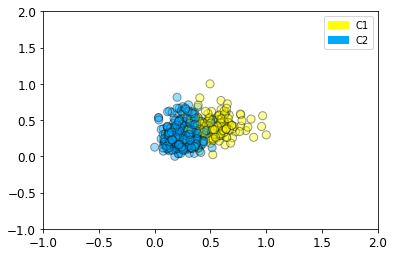

In [23]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(scaled)
plot_labelled_scatter(scaled, kmeans.labels_, ['C1', 'C2'])

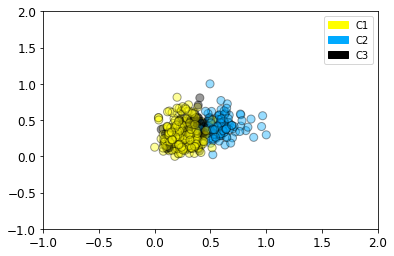

In [24]:
kmeans2 = KMeans(n_clusters=3)
kmeans2.fit(scaled)
plot_labelled_scatter(scaled, kmeans2.labels_, ['C1', 'C2','C3'])

### DBSCAN model
Apply DBSCAN model

use eps=0.2, min_samples=5

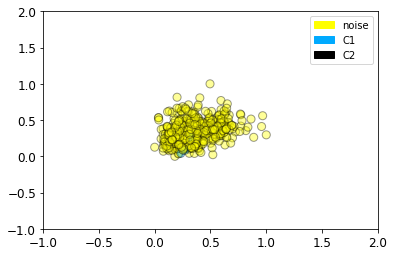

In [25]:
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(scaled)

plot_labelled_scatter(scaled, dbscan.labels_+1, ['noise', 'C1','C2'])


### (3) Evaluate Model performance: K-means vs. DBSCAN

##### evaluation method 1:

- print the sum of all correctly predicted data (y_predicted==y_cancer)

- Since we have y_cancer values, we compare the predicted value to its y_cancer value. The ratio of correctly predicted class can represent the accuracy of the model. 


##### evaluaton method 2:

- calculate Silhouette scores (examples are given in cluster_eval.ipynb)

In [26]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(scaled)
                for k in range(1, 10)]

In [27]:
maxRate = 0
maxK =0
correctRates =[]
y_preds = []
for k in range(1,10):
    countTrue = 0
    y_pred = kmeans_per_k[k - 1].labels_
    y_preds.append(y_pred)
    for i in range(len(y_pred)):
        y_predicted = y_preds[k-1][i]
        if  y_predicted==y_cancer[i]:
            countTrue = countTrue + 1

    correctRate = countTrue/len(y_cancer)
    correctRates.append(correctRate)
    if correctRate > maxRate:
        maxRate= correctRate
        maxK = k

    print(f'K= {k} : The ratio of correctly predicted: {correctRate* 100} % ')
print(f'\nK = {maxK}, have higest accuracy of the model, which is {maxRate * 100}%')

K= 1 : The ratio of correctly predicted: 37.258347978910365 % 
K= 2 : The ratio of correctly predicted: 7.205623901581721 % 
K= 3 : The ratio of correctly predicted: 5.0966608084358525 % 
K= 4 : The ratio of correctly predicted: 65.02636203866432 % 
K= 5 : The ratio of correctly predicted: 8.260105448154658 % 
K= 6 : The ratio of correctly predicted: 23.022847100175746 % 
K= 7 : The ratio of correctly predicted: 0.7029876977152899 % 
K= 8 : The ratio of correctly predicted: 1.4059753954305798 % 
K= 9 : The ratio of correctly predicted: 6.854130052724078 % 

K = 4, have higest accuracy of the model, which is 65.02636203866432%


Saving figure Accuracy_vs_k_plot


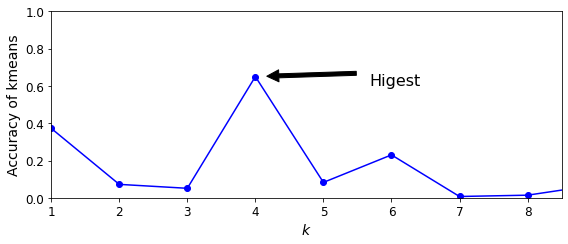

In [28]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), correctRates, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Accuracy of kmeans", fontsize=14)
plt.annotate('Higest',
             xy=(4, correctRates[3]),
             xytext=(0.65, 0.65),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1])
save_fig("Accuracy_vs_k_plot")
plt.show()

### Evaluation method 2: 

In [29]:
from sklearn.metrics import silhouette_score

In [30]:
silhouette_scores = [silhouette_score(scaled, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


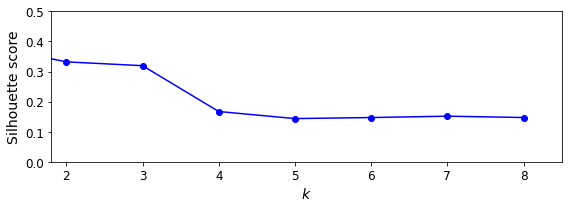

In [31]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 9), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0, 0.5])
save_fig("silhouette_score_vs_k_plot")
plt.show()

## Part 2

### Optimal parameters of clustering models

Pleae check the examples of k-means and DBSCAN models in the following notebook (available on TW9 page) and find out optimal parameters of each of the algorithms for the given dataset. 

- clustering_Kmeans.ipynb

- clustering_DBSCAN.ipynb


### Optimal parameters of clustering models by Kmeans

In [32]:
from sklearn.metrics import silhouette_score

In [33]:
silhouette_score(scaled, kmeans.labels_)

0.3845494883485513

In [34]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(scaled)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


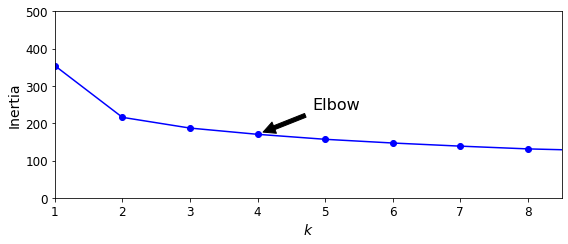

In [35]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 500])
save_fig("inertia_vs_k_plot")
plt.show()

In [36]:
silhouette_scores = [silhouette_score(scaled, model.labels_)
                     for model in kmeans_per_k[1:]]

In [37]:
silhouette_scores

[0.3845494883485513,
 0.3322499754550183,
 0.3195294099620425,
 0.16717796807210156,
 0.14367339937624066,
 0.14713996017964037,
 0.15164110703820666,
 0.1472170976123957]

Saving figure silhouette_score_vs_k_plot


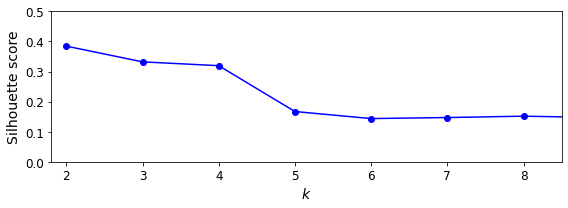

In [38]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0, 0.5])
save_fig("silhouette_score_vs_k_plot")
plt.show()

### As you can see, this visualization is much richer than the previous one: in particular, although it confirms that  𝑘=4  is a very good choice, but it also underlines the fact that  𝑘=5  is quite good as well.

### Optimal parameters of clustering models by clustering_DBSCAN

In [65]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(scaled)
dbscan2 = DBSCAN(eps=0.2, min_samples=5)
cu = dbscan2.fit(scaled)
dbscan3 = DBSCAN(eps=0.5, min_samples=5)
dbscan3.fit(scaled)
dbscan4 = DBSCAN(eps=1, min_samples=5)
dbscan4.fit(scaled)


DBSCAN(eps=1)

Saving figure dbscan_plot


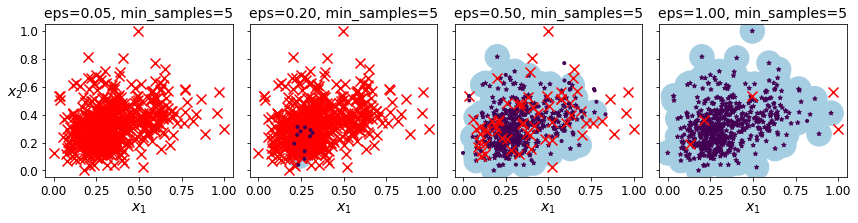

In [66]:
plt.figure(figsize=(12, 3.2))

plt.subplot(141)
plot_dbscan(dbscan, scaled, size=100)

plt.subplot(142)
plot_dbscan(dbscan2, scaled, size=600, show_ylabels=False)
plt.subplot(143)
plot_dbscan(dbscan3, scaled, size=600, show_ylabels=False)
plt.subplot(144)
plot_dbscan(dbscan4, scaled, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()


In [93]:
silhouettes = []
epsList = [0.3, 0.5, 0.7, 0.9, 1, 1.2, 1.4]
for r in epsList:
    db = DBSCAN(eps=r, min_samples=10).fit(scaled)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    score = silhouette_score(scaled, labels)
    silhouettes.append(score)

Saving figure silhouette_score_vs_DBSCAN


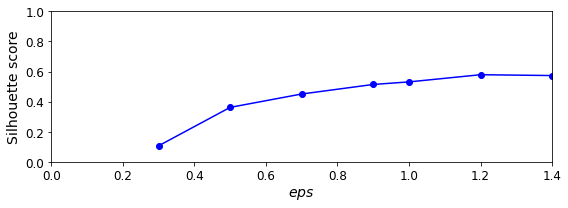

In [100]:
plt.figure(figsize=(8, 3))
plt.plot( epsList, silhouettes, "bo-")
plt.xlabel("$eps$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([0, 1.4, 0, 1])
save_fig("silhouette_score_vs_DBSCAN")
plt.show()


### Submissions:

- upload the notebook (clustering_basic.ipynb) on GitHub

- Write the link to the notebook on Canvas